## Generalised Perceptron

Binary classification based on MNIST and Fashion MNIST data. 

It restricts the classification problem to two classes, selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a binary classification (logistic regression) to learn to differentiate between the two categories.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from utils import read_data, plot_img, plot_tiles, plot_error, plot_cost 

In [3]:
x, y, labels_map = read_data('fashionMNIST') #MNIST or fashionMNIST

100.0%
100.0%
100.0%
100.0%


data is fashionMNIST, shape of x is (70000, 28, 28)
 , shape of y is (70000,)


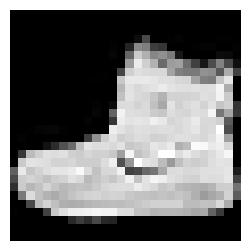

In [4]:
plot_img(x[0])

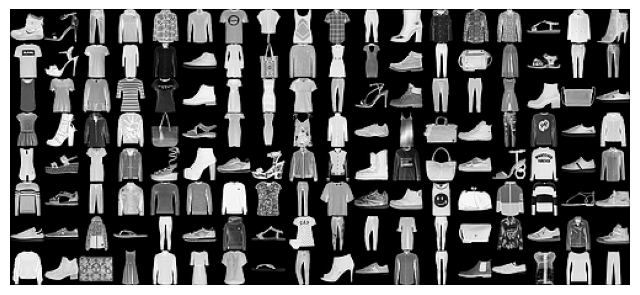

In [5]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]

plot_tiles(x, rows, cols, fig_size)

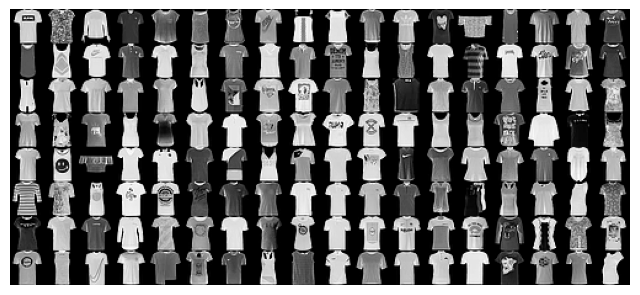

T-Shirt


In [6]:
#choose a given class 0..9
digit  = 0

plot_tiles(x[y == digit,:], rows, cols, fig_size)
print(labels_map[digit])

In [7]:
def prepare_data(digit_1, digit_2, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    digit_1 -- first digit ('True') to select
    digit_2 -- second digit ('False') to select
    train_size -- fraction of data used for training (0 < train_size < 1)
    min_max_normalise -- if 1, apply min-max-normalisation; if 0, apply simple rescaling (i.e. /255)
    flatten -- whether to flatten the 28x28 image to a single row
    """
    x_sel_1 = x[y == digit_1, :]
    x_sel_2 = x[y == digit_2, :]

    x_sel = np.append(x_sel_1, x_sel_2, axis=0)

    y_sel = np.append(np.ones((x_sel_1.shape[0], 1)),
                      np.zeros((x_sel_2.shape[0], 1)),
                      axis=0)

    num_samples = x_sel.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Reorder x_sel et y_sel selon indices mélangés
    x_sel = x_sel[indices]
    y_sel = y_sel[indices]

    # split
    max_train_ind = int(train_size * num_samples)

    x_train = x_sel[:max_train_ind]
    x_test  = x_sel[max_train_ind:]
    y_train = y_sel[:max_train_ind]
    y_test  = y_sel[max_train_ind:]

    x_train = x_train.astype(np.float32)
    x_test  = x_test.astype(np.float32)

    if min_max_normalise:
        # min–max normalisation: (x - min) / (max - min)
        train_min = x_train.min()
        train_max = x_train.max()
        x_train = (x_train - train_min) / (train_max - train_min + 1e-8)
        x_test  = (x_test  - train_min) / (train_max - train_min + 1e-8)
    else:
        # rescaling simple
        x_train /= 255.0
        x_test  /= 255.0

    if flatten:
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test  = x_test.reshape(x_test.shape[0], -1)

    return x_train, x_test, y_train, y_test


### Class NeuralNetwork

This class constructs a generalised perceptron. Cost function can be either MSE or CE (chosen in constructor). The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$

In [8]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    cost_MSE = 0
    cost_CE = 1
    
    def __init__(self, cost_function=cost_MSE, random_std = 0, size_in = 784):
        """
        constructor

        Arguments:
        cost_function -- can be cost_MSE (0, default) or cost_CE (1)
        random_std -- std for initialisation of weight (default is 0)
        size_in -- size of input image
        """
        self.size_in = size_in

        self.cost_function = cost_function
        
        #initialize weights and bias (zero or random)
        self.initialise_weights(random_std)
        
        # result array for cost and error of training and test set
        self.result_data = np.array([])
        self.result_data_dL = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 

        
    def initialise_weights(self, random_std):
        """
        initialize weights and bias (if random_std == 0 all weights are zero)
        """ 
        self.w = random_std*np.random.randn(self.size_in,1)
        self.b = 0
    
    
    def propagate(self, x):
        """
        predicted outcome for x
        """
        z = x @ self.w + self.b
        y_pred = self.activation_function(z)
                    
        return y_pred

    
    def activation_function(self, z):
        # Empêcher z de devenir trop grand ou trop petit
        z = np.clip(z, -15, 15)
        return 1 / (1 + np.exp(-z))

    
    
    
    def back_propagate(self, x, y_pred, y):
        """
        calculates the gradients of the cost function wrt w and b
        for MSE or CE (binary cross-entropy).
        """
        m = x.shape[0] 
    
        # d = la dérivée de perte par rapport à y_pred
        if self.cost_function == self.cost_MSE:
            # MSE + sigmoid
            d = (y_pred - y) * (y_pred * (1.0 - y_pred))
        else:
            # Cross-entropy + sigmoid
            d = (y_pred - y)
    
        # Calcul du gradient wrt w et b
        self.grad_w = (x.T @ d) / m  
        self.grad_b = np.mean(d)        
 
    
    
    def gradient_descend(self, alpha):
        """
        applies gradient descend step to w and b
        """
        self.w -= alpha * self.grad_w
        self.b -= alpha * self.grad_b
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        res = np.round(y_pred)        
        error = np.sum(np.abs(res - y)) / m 

        return error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function (MSE or Cross Entropy)
        """
        m = y.shape[0]
        
        if self.cost_function == self.cost_MSE:
            cost = np.mean((y_pred - y) ** 2)
        else:
            # Cross Entropy binaire :
            eps = 1e-8
            cost = - np.mean(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))
        return cost
    
    
    def append_result(self):
        """
        append cost and error data to output array
        """
        # determine cost and error functions for train and test data
        y_pred_train = self.propagate(self.data['x_train'])
        y_pred_test = self.propagate(self.data['x_test'])

        res_data = np.array([[self.cost_funct(y_pred_train, self.data['y_train']), 
                              self.calc_error(y_pred_train, self.data['y_train']),
                              self.cost_funct(y_pred_test, self.data['y_test']), 
                              self.calc_error(y_pred_test, self.data['y_test'])]])
        
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        #increase epoch counter here (used for plot routines below)
        self.epoch_counter += 1 
        
        return res_data
    
    
          
    def optimise(self, data, epochs, alpha, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        debug -- False (default)/True; get info on gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.append_result()

        for i0 in range(0, epochs):            
            y_pred = self.propagate(data['x_train'])
            self.back_propagate(data['x_train'], y_pred, data['y_train'])
            self.gradient_descend(alpha)
          
            res_data = self.append_result()
                      
            if debug and np.mod(i0, debug) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f'
                                          % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))

        if debug:
            print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f'
                  % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))
    

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. This method can be called several times in a row with different arguments.

result after 1 epochs, train: cost 6.31479, error 0.49893 ; test: cost 6.40807, error 0.50429
result after 101 epochs, train: cost 0.13353, error 0.03920 ; test: cost 0.12109, error 0.03857
result after 201 epochs, train: cost 0.11546, error 0.03491 ; test: cost 0.10701, error 0.03643
result after 301 epochs, train: cost 0.11144, error 0.03268 ; test: cost 0.10470, error 0.03750
result after 401 epochs, train: cost 0.10867, error 0.03268 ; test: cost 0.10307, error 0.03679
result after 500 epochs, train: cost 0.10654, error 0.03214 ; test: cost 0.10195, error 0.03714
result after 501 epochs, train: cost 0.10653, error 0.03214 ; test: cost 0.10195, error 0.03714
result after 601 epochs, train: cost 0.10561, error 0.03205 ; test: cost 0.10152, error 0.03607
result after 701 epochs, train: cost 0.10477, error 0.03179 ; test: cost 0.10115, error 0.03571
result after 801 epochs, train: cost 0.10400, error 0.03170 ; test: cost 0.10083, error 0.03536
result after 901 epochs, train: cost 0.103

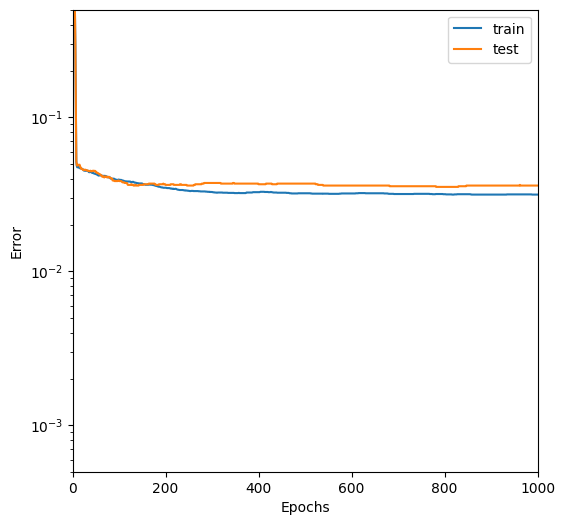

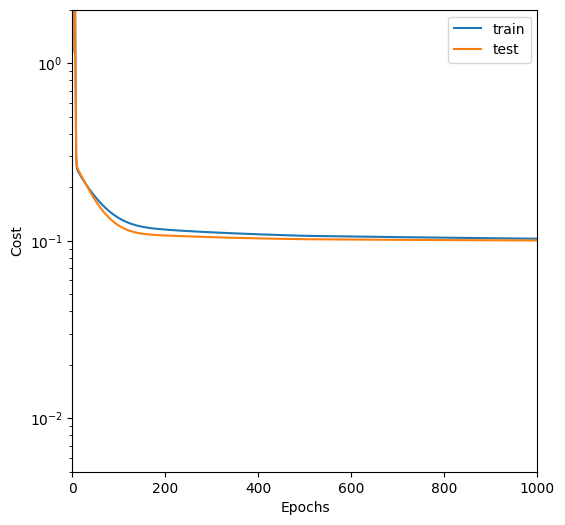

In [9]:
x_train, x_test, y_train, y_test = prepare_data(0, 2, train_size=0.8, min_max_normalise=0, flatten=1)

data = {'x_train' : x_train, 'y_train' : y_train, 'x_test' : x_test, 'y_test' : y_test}


NNet = NeuralNetwork(cost_function=1, random_std = 0.2, size_in = 784)

NNet.optimise(data, 500, 0.5, debug=100)
NNet.optimise(data, 500, 0.25, debug=100)

plot_error(NNet)
plot_cost(NNet)

(101, 784)


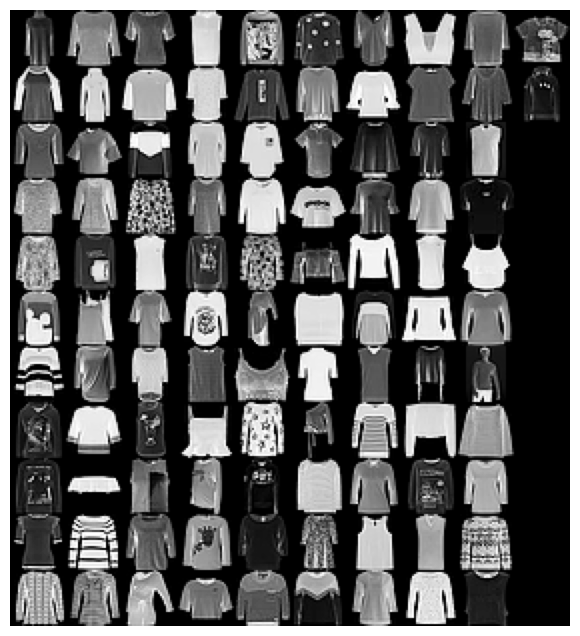

In [19]:
#analyse false classified training or test images
y_pred = np.round(NNet.propagate(data['x_test']))
false_classifications = data['x_test'][(y_pred != data['y_test'])[:,0]]

print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 11
cols = 11
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications, rows, cols, fig_size)

In [23]:
print(y_pred[:20])

[0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0]


### subpoint (d)

Run the training (chosing an appropriate learning rate and number of epochs) both on
MSE and CE and determine the matrices for any combinations of binary classications
possible (c.f. Table 1 in FTP_DeLearn_Lecture-Notes).

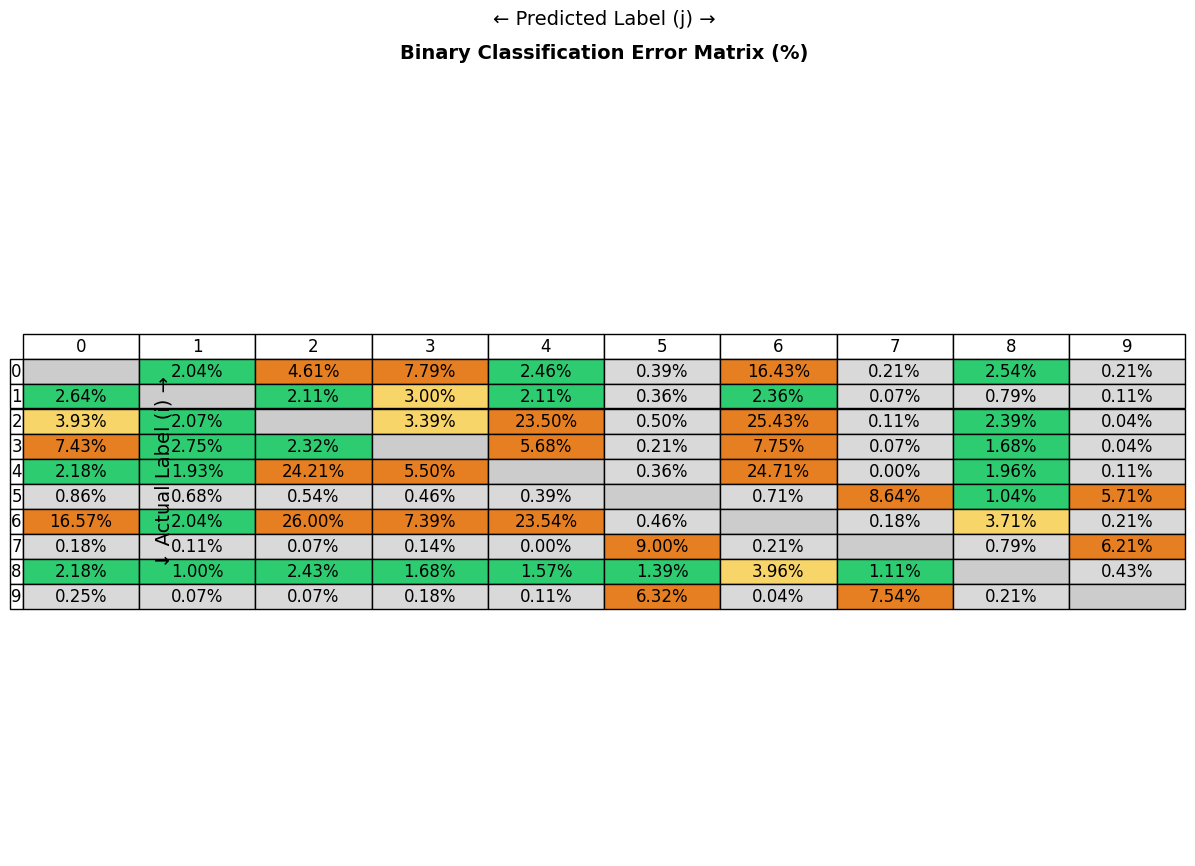

In [24]:
# Define all 10 digits
digits = np.arange(10)
error_matrix = np.zeros((10, 10))  # Initialize matrix to store error rates

# Loop through all pairs of digits (i, j)
for i in digits:
    for j in digits:
        if i == j:
            error_matrix[i, j] = np.nan  # No classification needed for same digits
            continue
        
        # Prepare binary classification dataset
        x_train, x_test, y_train, y_test = prepare_data(i, j, train_size=0.8)

        # Train Neural Network
        NNet = NeuralNetwork(cost_function=NeuralNetwork.cost_CE, random_std=0.01, size_in=x_train.shape[1])
        NNet.optimise({'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}, 
                      epochs=100, alpha=0.1)

        # Make predictions
        y_pred = np.round(NNet.propagate(x_test))

        # Compute classification error
        error_rate = np.mean(y_pred != y_test) * 100  # Convert to percentage
        error_matrix[i, j] = error_rate

# Define function to color cells based on value
def get_color(val):
    if np.isnan(val):
        return "#cccccc"  # Grey for NaN
    elif val < 1:
        return "#d9d9d9"  # Light gray for near-perfect classification
    elif val < 3:
        return "#2ecc71"  # Green for low error
    elif val < 4:
        return "#f8d568"  # Yellow for moderate error
    else:
        return "#e67e22"  # Orange for high misclassification

# Convert matrix to formatted text and colors
cell_text = [["{:.2f}%".format(val) if not np.isnan(val) else "" for val in row] for row in error_matrix]
cell_colors = [[get_color(val) for val in row] for row in error_matrix]

# Plot table
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()

table = ax.table(cellText=cell_text,
                 cellColours=cell_colors,
                 cellLoc='center',
                 rowLabels=digits, 
                 colLabels=digits, 
                 loc='center')

# Style table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

# Add labels and title
plt.text(0.5, 1.08, "← Predicted Label (j) →", fontsize=14, ha='center', transform=ax.transAxes)
plt.text(-0.08, 0.5, "↓ Actual Label (i) →", fontsize=14, va='center', rotation=90, transform=ax.transAxes)
plt.title("Binary Classification Error Matrix (%)", fontsize=14, fontweight="bold", pad=20)

# Show table
plt.show()


### subpoint (e)

For MSE cost only do 10 successive training runs and determine the average and standard
deviation of the nal error rates obtained (c.f. Table 2 in FTP_DeLearn_Lecture-Notes).

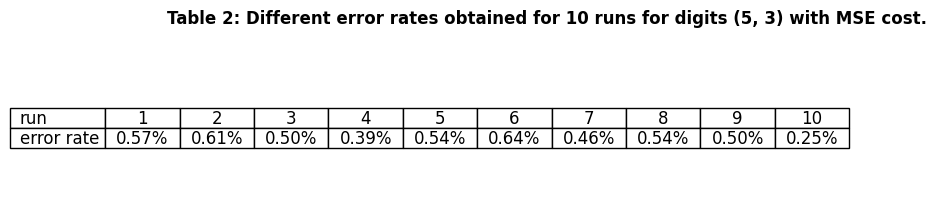

Average Error Rate: 0.50%
Standard Deviation of Error Rate: 0.11%


In [25]:
# Define number of runs
num_runs = 10
error_rates = []

# Select the two digits for binary classification
digit_1, digit_2 = 5, 3

# Perform 10 independent training runs
for run in range(num_runs):
    # Prepare binary classification dataset for chosen digits
    x_train, x_test, y_train, y_test = prepare_data(digit_1, digit_2, train_size=0.8)

    # Initialize Neural Network with MSE cost function
    NNet = NeuralNetwork(cost_function=NeuralNetwork.cost_MSE, random_std=0.01, size_in=x_train.shape[1])
    
    # Train the network
    NNet.optimise({'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}, 
                  epochs=100, alpha=0.1)
    
    # Make predictions
    y_pred = np.round(NNet.propagate(x_test))

    # Compute classification error rate
    error_rate = np.mean(y_pred != y_test) * 100  # Convert to percentage
    error_rates.append(error_rate)

# Compute statistics
avg_error = np.mean(error_rates)
std_dev_error = np.std(error_rates)

# Prepare table data
columns = [str(i+1) for i in range(num_runs)]  # Run numbers (1-10)
row_data = ["{:.2f}%".format(err) for err in error_rates]  # Error rates formatted as percentages

# Plot table
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_axis_off()

# Table contents
table_data = [columns, row_data]
row_labels = ["run", "error rate"]

table = ax.table(cellText=table_data,
                 cellLoc='center',
                 rowLabels=row_labels,
                 colLabels=None,
                 loc='center')

# Style table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Add title
plt.title("Table 2: Different error rates obtained for 10 runs for digits ({}, {}) with MSE cost.".format(digit_1, digit_2), 
          fontsize=12, fontweight="bold", loc='left', pad=20)

# Display table
plt.show()

# Print summary statistics
print(f"Average Error Rate: {avg_error:.2f}%")
print(f"Standard Deviation of Error Rate: {std_dev_error:.2f}%")


# Exercices answers (calculations)

## Exercise 1

### (a) Compute the derivative of the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\sigma(z) = (1 + e^{-z})^{-1}
$$

$$
\sigma'(z) = -1 \cdot (1 + e^{-z})^{-2} \cdot \frac{d}{dz}(1 + e^{-z})
$$

$$
\frac{d}{dz}(1 + e^{-z}) = -e^{-z}
$$

$$
\sigma'(z) = -(1 + e^{-z})^{-2} \cdot (-e^{-z}) = \frac{e^{-z}}{(1 + e^{-z})^2}
$$

---

### (b) Show that the derivative fulfills the equation:

$$
\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))
$$

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\sigma'(z) = \frac{e^{-z}}{(1 + e^{-z})^2}
$$

$$
\sigma'(z) = \frac{1}{1 + e^{-z}} \cdot \frac{e^{-z}}{1 + e^{-z}}
= \sigma(z) \cdot \left(\frac{e^{-z}}{1 + e^{-z}}\right)
$$

$$
\frac{e^{-z}}{1 + e^{-z}}
= 1 - \frac{1}{1 + e^{-z}}
= 1 - \sigma(z)
$$

$$
\sigma'(z) = \sigma(z) \cdot \left(1 - \sigma(z)\right)
$$